<h1 style="font-size:40px;"><center>Exercise III:<br> Convolutional and Recurrent Neural Networks
</center></h1>

# Short summary
In this exercise you will:

* Train CNNs for a binary classification problem
* Visualize how CNNs interprets the data
* Train CNNs for two 3-class classification problem
* Train a RNN on a time series prediction problem
* Visualize RNN hidden node activities

In this computer exercise we will look at network architectures that are designed to handle specific kinds of data: Convolutional Neural Networks for image processing and Recurrent Neural Networks for time series processing

**Deadline for submitting the report: See Canvas assignment.**

## The data
Digits "5" and "6" from the MNIST database used for a binary classification problem.

A dataset consisting of circles, rectangles or triangles, that can be read using the `loadImagesCRT` function.

A dataset consisting of three different types of rectangles, squares, "horizontal" rectangles and "vertical" rectangles. This data can be read using the `loadImagesR3` function.

A dataset consisting of pairs of times series. The input time series is a train of rectangle pulses, and the output is triangles, i.e. an up-ramp followed by a down-ramp. For more details see the cell *Ex4-1*. The task is to train a recurrent network that predicts the triangle time series from the pulse time series.


## The exercises
As with the previous computer exercises, all problems are found below.

## The different "cells"
This notebook contains several cells with python code, together with the markdown cells (like this one) with only text. Each of the cells with python code has a "header" markdown cell with information about the code. The table below provides a short overview of the code cells.

| #  |  CellName | CellType | Comment |
| :--- | :-------- | :-------- | :------- |
| 1 | Init | Needed | Sets up the environment|
| 2 | Data | Needed | Loading images for the CNN exercise |
| 3 | PlotImg | Information  | View some of the images |
| 4 | CNN Network | Needed | Defines the Network class for CNNs |
| 5 | Stats | Needed | Show classification results and confusion matrix |
| 6 | Metrics | Needed | Various metrics for model validation |
| 7 | Training | Needed | Functions for training and testing the CNN model |
| 8 | Visualization | Needed | Visualizes layers of a CNN |
| 9 | RNN | Needed | Defines network and training for recurrent networks |
| 10 | Ex1 | Exercise | For question 1-2 |
| 11 | Ex2 | Exercise | For question 3 |
| 12 | Ex3 | Exercise | For question 4-5 |
| 13 | Ex4-1 | Exercise | For question 6-9 |
| 14 | Ex4-2 | Exercise | For question 6-9 |
| 15 | Ex4-3 | Exercise | For question 6-9 |


In order for you to start with the exercise you need to run all cells with the CellType "Needed". The very first time you start with this exercise we suggest that you enter each of the needed cells, read the cell instruction and run the cell. It is important that you do this in the correct order, starting from the top and work you way down the cells. Later when you have started to work with the notebook it may be easier to use the command "Run All" found in the "Cell" dropdown menu.

## Writing the report
First the report should be written within this notebook. We have prepared the last cell in this notebook for you where you should write the report. The report should contain 4 parts:

* Name.
* Introduction: A **few** sentences where you give a small introduction of what you have done in this exercise.
* Answers to questions: For each of the questions provide an answer. It can be short answers or longer ones depending on the nature of the questions, but try to be efficient in your writing.
* Conclusion: Summarize your findings in a few sentences.

It is important that you write the report in this last cell and **not** after each question!

## Last but not least
Have fun again!

# CellName: Init (#1)
**CellType: Needed**  
**Cell instruction: Initializing the libraries**

In the cell below, we import all the libraries that are needed for this exercises.

Run the cell by entering into the cell and press "CTRL Enter".


In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Uncomment this to use CUDA acceleration if available
# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"PyTorch: Using {device} device")
# The floating point data type can be changed here
dtype_torch = torch.float32

from torch.utils.data import DataLoader, TensorDataset
from torch import nn, Tensor
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import itertools

from sklearn.metrics import confusion_matrix, log_loss, classification_report

PyTorch: Using cpu device


# CellName: Data (#2)
**CellType: Needed**  
**Cell instruction: Function for getting images for the CNN exercises**

This cell defines the functions that obtain the images needed for the CNN exercise. **Note**: Make sure the "crt-trn/" and "crt-tst/" folders are available in the same directory as this notebook file when you actually call these functions. Otherwise, the files files are not found.

Run the cell by entering into the cell and press "CTRL Enter".

In [13]:
basedir = "./BERN04_ANN_DeepLearning/Lab_3/"

def loadImagesCRT():
    xtrain, ytrain, xval, yval = np.load(basedir + "crt.npy", allow_pickle=True)
    width, height = xtrain.shape[2:]
    return xtrain, ytrain, xval, yval, width, height

def loadImagesR3():
    xtrain, ytrain, xval, yval = np.load(basedir + "r3.npy", allow_pickle=True)
    width, height = xtrain.shape[2:]
    return xtrain, ytrain, xval, yval, width, height

def loadMNIST56():
    xtrain, ytrain, xval, yval = np.load(basedir + "mnist56t.npy", allow_pickle=True)
    width, height = xtrain.shape[2:]
    return xtrain, ytrain, xval, yval, width, height

# CellName: PlotImg (#3)
**CellType: Information**  
**Cell instruction: Show some of the images**

Here we look at the first ten pictures in the training set, and their respective targets. You can select the dataset to look at by uncomment the correct line.

Run the cell by entering into the cell and press "CTRL Enter".

In [8]:
!git clone https://github.com/myngoc-trg/BERN04_ANN_DeepLearning.git

Cloning into 'BERN04_ANN_DeepLearning'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 184 (delta 99), reused 29 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (184/184), 18.60 MiB | 14.41 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [11]:
!ls /content/BERN04_ANN_DeepLearning/Lab_3/

crt.npy     mnist56t.npy	pulsedata1-val.npy  pulsedata2-val.npy
lab3.ipynb  pulsedata1-trn.npy	pulsedata2-trn.npy  r3.npy


In [12]:
!find . -name '*.npy'

./BERN04_ANN_DeepLearning/Lab_3/pulsedata1-trn.npy
./BERN04_ANN_DeepLearning/Lab_3/pulsedata1-val.npy
./BERN04_ANN_DeepLearning/Lab_3/crt.npy
./BERN04_ANN_DeepLearning/Lab_3/pulsedata2-trn.npy
./BERN04_ANN_DeepLearning/Lab_3/mnist56t.npy
./BERN04_ANN_DeepLearning/Lab_3/r3.npy
./BERN04_ANN_DeepLearning/Lab_3/pulsedata2-val.npy


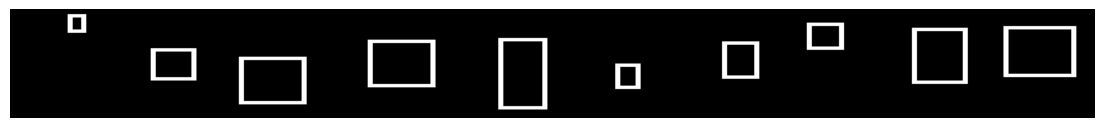

In [14]:
xTrn, dTrn, xVal, dVal, width, height = loadMNIST56()
#xTrn, dTrn, xVal, dVal, width, height = loadImagesCRT()
xTrn, dTrn, xVal, dVal, width, height = loadImagesR3()

rndSel = np.random.randint(len(xTrn), size=10)
plt.figure(1, figsize=(14,6))
plt.imshow(xTrn[rndSel,0,:,:].swapaxes(0,1).reshape(width, 10*height), cmap="gray")
plt.axis("off")
plt.show()

# CellName: CNN network (#4)
**CellType: Needed**  
**Cell instruction: Defining the ANN model**

This cell defines a generic ANN model. In the two earlier computer exercises, it was sufficient to specify the number of nodes in each layer. Now you'll have to specify the layers in more detail through an `OrderedDict` of `Module`s from `nn`. Examples of modules are:
* `nn.Linear` – fully connected layer
* `nn.Conv2d` – 2D convolutional layer
* `nn.MaxPool2d` – 2D maxpooling layer
* `nn.ReLU` and `nn.Softmax` – activation layers
* `nn.Dropout` – dropout layer

Many of these require settings such as the input and output dimensions, kernel size, stride or what dimension of the input to operate on.

In the exercise sections you'll see examples of how to specify layers in the `OrderedDict` that will be passed to `Network`. Note that you actually create the layers already there, and the `Network` then uses an `nn.Sequential` to connect them. When we train the network, Pytorch manages the dependencies between the network weights/biases and the output for us.

* seqstack: the `OrderedDict` explained above.
* l2regularization: L2 regularization strength for `Linear` layers.

Run the cell by entering into the cell and press "CTRL Enter".

In [15]:
class Network(nn.Module):
    "A generic network with optional L2 regularization"
    def __init__(self, seqstack : OrderedDict, *, l2regularization=None):
        """
        Args:
            seqstack (OrderedDict): The layers of the network.
            l2regularization (float or dict, optional): Regularization strength for all linear layers or for named layers.
        """
        super().__init__()

        self.layer_stack = nn.Sequential(seqstack)
        if isinstance(l2regularization, dict):
            self.l2regularization = [(lambd, seqstack[name]) for name, lambd
                                     in l2regularization.items()]
        elif l2regularization:
            self.l2regularization = [
                (l2regularization, layer) for layer in seqstack.values()
                if isinstance(layer, nn.Linear)]
        else:
            self.l2regularization = None

    def forward(self, x):
        "Apply the network stack on some input"
        return self.layer_stack(x)

    def regularization_loss(self):
        "Compute the total regularization cost"
        if self.l2regularization is None:
            return 0
        loss = 0
        for lambd, layer in self.l2regularization:
            loss = loss + lambd * torch.norm(layer.weight, p=2)
        return loss

    def get_layer(self, name : str):
        "Get layer by name"
        module_dict = dict(self.layer_stack.named_modules())
        return module_dict[name]

    def predict(self, input_data):
        """
        Apply the network on a set of input data.

        Args:
            input_data (np.ndarray or Tensor): Input data

        Returns:
            pred (np.ndarray or Tensor): Predicted output.
        """
        self.eval()
        if isinstance(input_data, np.ndarray):
            inp = torch.tensor(input_data, dtype=dtype_torch, device=device)
            with torch.no_grad():
                pred = self(inp)
            return pred.cpu().detach().numpy()
        with torch.no_grad():
            return self(input_data.to(device))

    def __str__(self):
        s = super().__str__()
        ps = ["Named parameters:"] + [
            f"{name}: {param.numel()}" for name, param in
             self.layer_stack.named_parameters() if param.requires_grad]
        totp = sum(p.numel() for p in self.layer_stack.parameters() if p.requires_grad)
        return s + f"\nTrainable parameters: {totp}\n" + "\n  ".join(ps) + "\n"

# CellName: Stats (#5)
**CellType: Needed**  
**Cell instruction: Show classification results**

This cell just defines functions that we can call to compute some performance measures for classification problems.

Run the cell by entering into the cell and press "CTRL Enter".

In [16]:
def stats_classification(model : Network, dset : TensorDataset,
                         *, label : str, loss_fn = None):
    """
    Print classification statistics.

    Args:
        model (Network): The model.
        dset (TensorDataset): Input and target data.
        label (str): Training, test etc.
        loss (optional): Loss function.

    Returns:
        None.
    """
    pred = model.predict(dset.tensors[0])
    targ = dset.tensors[1]
    if loss_fn is not None:
        loss = loss_fn(pred, targ)

    if targ.shape[1] == 1:
        # Binary
        pred = pred >= .5
        targ = targ >= .5
        nof_p, tp, tn = [k.sum() for k in [targ, pred[targ], ~pred[~targ]]]
        stats = {'Accuracy': (tp + tn) / len(targ),
                 'Sensitivity': tp / nof_p,
                 'Specificity': tn / (len(targ) - nof_p)}
    else:
        # One-hot
        pred = pred.argmax(axis=1)
        targ = targ.argmax(axis=1)
        stats = {'Accuracy': (pred == targ).sum() / len(targ)}

    if loss_fn is not None:
        stats['Loss'] = loss

    print(f"*** STATISTICS for {label} Data ***")
    for l, v in stats.items():
        print(f'{l:15} {v:.4f}')
    print()

def plot_confusion_matrix(cm, target_names, title='Confusion matrix',
                          cmap=None, normalize=True):
    "Plot a confusion matrix"

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n'
               f'accuracy={accuracy:0.4f}; misclass={misclass:0.4f}')
    plt.show()

def make_cm_plot(model, inp, trg, label='Test data'):
    """
    Compute and plot the confusion matrix
    """
    print(f'*** Result for {label} ***')

    num_classes = trg.shape[1]
    y = model.predict(inp)

    print(f'log_loss:   {log_loss(trg, y):.4f}')
    d_class = trg.argmax(axis=1)
    y_class = y.argmax(axis=1)
    acc = (y_class==d_class).mean()
    print(f'accuracy:   {acc:.4f}\n')

    class_names = [f'class {i+1}' for i in range(num_classes)]
    print(classification_report(d_class, y_class, target_names=class_names))

    confuTst = confusion_matrix(d_class, y_class)
    plot_confusion_matrix(cm           = confuTst,
                          normalize    = False,
                          target_names = class_names,
                          title        = f"Confusion Matrix, {label}")

# CellName: Metrics (#6)
**CellType: Needed**  
**Cell Instruction: Functions for evaluating various metrics during training**

Run the cell by entering into the cell and press "CTRL Enter".

In [17]:
class SimpleMetric():
    """ Base class for any metric that keeps a numerator and denominator,
    designed as a simple drop-in replacement for torchmetrics.
    """
    def __init__(self, v=None):
        if v is not None:
            self.v = v
        else:
            self.v = torch.zeros(2)

    def reset(self):
        self.v = torch.zeros_like(self.v)

    def to(self, device):
        v = self.v.to(device)
        return self if v is self.v else type(self)(v)

    def compute(self):
        return self.v[0] / self.v[1]

class MSEMetric(SimpleMetric):
    """ Mean square error metric.
    """
    def update(self, pred, y):
        self.v[0] += ((pred - y)**2).sum()
        self.v[1] += y.numel()

class BinaryAccuracyMetric(SimpleMetric):
    """ Binary accuracy metric. Predictions will be thresholded at 0.5.
    """
    def update(self, pred, y):
        if pred.is_floating_point():
            pred = pred >= .5
        self.v[0] += (pred == y).sum()
        self.v[1] += y.numel()

class ClassificationAccuracyMetric(SimpleMetric):
    """ One-hot classification accuracy metric.
    """
    def update(self, pred, y):
        y = y.argmax(-1)
        pred = pred.argmax(-1)
        self.v[0] += (pred == y).sum()
        self.v[1] += y.numel()

class ClassificationErrorMetric():
    """ One-hot classification metric base class.
    """
    def __init__(self, num_classes, v=None):
        self.num_classes = num_classes
        if v is not None:
            self.v = v
        else:
            self.v = torch.zeros(self.num_classes, self.num_classes,
                                 dtype=torch.int64)

    def reset(self):
        self.v = torch.zeros_like(self.v)

    def to(self, device):
        v = self.v.to(device)
        return self if v is self.v else type(self)(self.num_classes, v)

    def update(self, pred, y):
        y = y.argmax(-1)
        pred = pred.argmax(-1)
        self.v.index_put_((y, pred),
            torch.ones_like(y, dtype=self.v.dtype),
            accumulate=True)

class ClassificationF1Metric(ClassificationErrorMetric):
    """ One-hot classification macro F1 score metric.
    """
    def compute(self):
        tp = torch.diag(self.v)
        f1 = 2 * tp / (self.v.sum(0) + self.v.sum(1))
        return f1.mean()

# CellName: Training (#7)
**CellType: Needed**  
**Cell Instruction: Functions for training and testing the model**

Like in the previous exercises, this cell defines functions for training the model for a single epoch (`train_epoch`),
evaluating the performance (`test`) and training and testing a previously defined `Network` model over many epochs (`train_loop`).

* loss_fn: The error function used during training. There are three common ones
    * `nn.MSELoss` (mean squared error)
    * `nn.BCELoss` (binary cross entropy)
    * `nn.CrossEntropyLoss` (categorical cross entropy)<p>

Run the cell by entering into the cell and press "CTRL Enter".

In [18]:
def test(*, model : Network, dataloader : DataLoader, loss_fn, metrics=[]):
    """
    Test a model on a set of data.

    Args:
        model (Network): The network.
        dataloader (DataLoader): DataLoader with data to test.
        loss_fn (Loss): Loss function, e.g. nn.MSELoss.
        metrics (iterable): Additional metrics to update.

    Returns:
        loss (float): Mean error over all batches.
    """
    model.eval()
    loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item() * len(X)
            for m in metrics:
                m.update(pred, y)
    return loss / len(dataloader.dataset)


def train_loop(*, model : Network, train_dataloader : DataLoader,
               val_dataloader : DataLoader = None, loss_fn,
               optimizer : torch.optim.Optimizer, epochs : int,
               print_every:int = 100, metrics=None, print_final=True):
    """
    Train and optionally test a model.

    Args:
        model (Network): The network.
        train_dataloader (DataLoader): Training data.
        val_dataloader (DataLoader, optional): Validation data.
        loss_fn (Loss): Loss function, e.g. nn.MSELoss.
        optimizer (Optimizer): An optimizer from torch.optim.
        epochs (int): Number of epochs to train for.
        print_every (int, optional): Print loss every so many epochs. Defaults to 100.
        metrics (dict(name: metric), optional): Record/print these additional metrics.
        print_final(bool, optional): Print final metrics. Defaults to True.

    Returns:
        train_losses (list(float)): Training loss during each epoch.
        val_losses (list(float)): Validation loss after each epoch.
        metrics_res (dict(name: list(float))): Values of metrics after each epoch.
    """
    train_losses = []
    val_losses = []
    val_loss = np.nan

    # Move metrics to CPU/GPU and prepare for their output
    metrics = {name: m.to(device) for name, m in (metrics or {}).items()}
    metrics_res = {name+"-t": [] for name in metrics.keys()}
    metrics_res.update({name+"-v": [] for name in metrics.keys()})

    for t in range(epochs):
        for m in metrics.values():
            m.reset()
        train_loss = train_epoch(model=model, dataloader=train_dataloader,
                           loss_fn=loss_fn, optimizer=optimizer,
                           metrics=metrics.values())
        train_losses.append(train_loss)
        for name, m in metrics.items():
            metrics_res[name+"-t"].append(m.compute().cpu())

        if val_dataloader is not None:
            for m in metrics.values():
                m.reset()
            val_loss = test(dataloader=val_dataloader, model=model,
                            loss_fn=loss_fn, metrics=metrics.values())
            val_losses.append(val_loss)
            for name, m in metrics.items():
                metrics_res[name+"-v"].append(m.compute().cpu())

        if (print_every > 0 and t % print_every == 0) or (
                print_every >= 0 and t + 1 == epochs):
            extras = [f" {n} {v[-1]:<7f}" if torch.isreal(v[-1])
                      else f" {n} {v[-1]}"
                      for n, v in metrics_res.items()]
            print(f"Epoch {t+1:<7d} train {train_loss:<7f} "
                  f" validation {val_loss:<7f}", "".join(extras))
    if print_final:
        print("\n** Validation metrics after training **\n"
              f"Loss {val_losses[-1]:<7g}")
        for n, v in metrics_res.items():
            if torch.isreal(v[-1]):
                print(f"{n} {v[-1]:<7g}")
            else:
                print(f"{n}:")
                print(v[-1])
        print()
    return train_losses, val_losses, metrics_res

def train_epoch(*, model : Network, dataloader : DataLoader,
                loss_fn, optimizer : torch.optim.Optimizer, metrics=[]):
    """
    Train a model for a single epoch.

    Args:
        model (Network): The network.
        dataloader (DataLoader): Batch DataLoader with training data.
        loss_fn (Loss): Loss function, e.g. nn.MSELoss.
        optimizer (Optimizer): The optimizer used to update the network.
        metrics (iterable): Additional metrics to update.

    Returns:
        train_loss (float): Training error over all batches.
    """
    model.train()
    train_loss = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)   # Move data to GPU if necessary
        optimizer.zero_grad()   # Reset the gradients

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item() * len(X)
        loss = loss + model.regularization_loss()
        for m in metrics:
            m.update(pred.detach(), y)

        # Backpropagation
        loss.backward()
        optimizer.step()
    return train_loss / len(dataloader.dataset)

def plot_training(train_loss, val_loss, metrics_res={}):
    "Plot the training history"
    plt.figure()
    plt.ylabel('Loss / Metric')
    plt.xlabel('Epoch')
    plt.plot(train_loss, label="Training loss")
    plt.plot(val_loss, label="Validation loss")
    for name, res in metrics_res.items():
        if torch.isreal(res[0]):
            plt.plot(res, label=name)
    plt.legend(loc='best')
    plt.show()

# CellName: Visualization (#8)
**CellType: Needed**  
**Cell instruction: Function that can visualize the different layers of a CNN**

This cell is feeding an image through a CNN and stores the intemediate values. It plots the different layers (filtered images) either before or after maxpooling.

Run the cell by entering into the cell and press "CTRL Enter".

In [19]:
def layerVisualization(model : Network, layernames : list,
                       indata, target, idx=10):
    # Catch the output of the layer
    ind = indata[[idx]]
    plot_data = [ind]
    def hook(model, input, output):
        plot_data.append(output.detach().numpy())

    handles = []
    for name in layernames:
        layer = model.get_layer(name)
        handles.append(layer.register_forward_hook(hook))

    pred = model.predict(ind)
    for handle in handles:
        handle.remove()

    print('Prediction: ', pred)
    print('Target    : ', target[idx])

    plt.figure(tight_layout=True)
    # plt.figure(figsize=(18,12), tight_layout=True)
    for k, s in enumerate(plot_data):
        plt.subplot(len(plot_data), 1, k+1)
        pics = s[0]
        # pics = np.rollaxis(pics,2,0)
        rows = 2 if pics.shape[0] > 8 else 1
        cols = pics.shape[0]//rows
        pad = pics.shape[0]-rows*cols
        if pad > 0:
            padding = np.zeros_like(pics, shape=(rows-pad,)+pics.shape[1:])
            pics = np.concatenate([pics, padding])
            cols = cols + 1
        imgshape = pics.shape[1:]
        pics = pics.reshape((rows,cols)+imgshape)
        pics = pics.swapaxes(1,2)
        pics = pics.reshape((pics.shape[0]*pics.shape[1], pics.shape[2]*pics.shape[3]))
        extent = (0, cols*imgshape[0], 0,rows*imgshape[1])
        plt.imshow(pics,cmap='gray',extent=extent)
        for r in range(1,rows):
            plt.plot([0,cols*imgshape[0]], [r*imgshape[1], r*imgshape[1]], color='r', linestyle='-', linewidth=1)
        for c in range(1,cols):
            plt.plot([c*imgshape[0], c*imgshape[0]], [0,rows*imgshape[1]], color='r', linestyle='-', linewidth=1)

# CellName: RNN (#9)
**CellType: Needed**  
**Cell instruction: Class defining recurrent networks and function for training them**

This cell defines a generic recurrent model, with a class `StatefulNetwork` which can hold several recurrent layers and a memory of their state.

The options are more limited here than in the previous exercises: You can select the type of network nodes and the number of hidden layers and nodes. For the simple RNNs you can also choose between tanh and relu activation functions (`nonlinearity`).

The `train_TBPTT` function performs *truncated back-propagation through time* on a network. The time series data is assumed to consist of a single quantity (the pulse level) over a constant number of timepoints. Data are divided into batches by `DataLoader` and further divided into time segments of length `truncationlen`.

Arguments to this function are:
 * `epochs` the number of epochs
 * `truncationlen` the number of time points between weight updates *and* the depth of back-propagatation through time.

Run the cell by entering into the cell and press "CTRL Enter".

In [20]:
class StatefulNetwork(nn.Module):
    "A recurrent network for BPTT"
    def __init__(self, nettype, nodes=[10], **kwargs):
        """
        Args:
            nettype (type): Network type, e.g. nn.RNN, nn.GRU or nn.LSTM.
            nodes (list of int): The number of nodes in each hidden layer.
            kwargs: nettype-specific arguments. For RNN there is one option:
                nonlinearity can be 'relu' or 'tanh' (default)
        """
        super().__init__()
        self.rnns = nn.ModuleList()
        prevn = 1
        for n in nodes:
            self.rnns.append(
                nettype(prevn, hidden_size=n, batch_first=True,
                        device=device, dtype=dtype_torch, **kwargs))
            prevn = n
        self.fc = nn.Linear(prevn, 1)
        self.reset_hidden_state()

    def reset_hidden_state(self):
        "Clear hidden state memory"
        self.hidden = [None] * len(self.rnns)

    def forward(self, x):
        "Apply the network to a batch of data."
        for i, rnn in enumerate(self.rnns):
            x, hx = rnn(x, self.hidden[i])
            # Detach hidden states to stop backpropagation
            if isinstance(hx, tuple): # For LSTM (hidden state, cell state)
                self.hidden[i] = tuple(t.detach() for t in hx)
            else:
                self.hidden[i] = hx.detach()
        return self.fc(x)

    def predict(self, input_data):
        """
        Apply the network on a set of input data.
        """
        self.eval()
        self.reset_hidden_state()
        inp = torch.tensor(input_data, dtype=dtype_torch, device=device)
        with torch.no_grad():
            pred = self(inp)
        return pred.cpu().numpy()

    def __str__(self):
        s = super().__str__()
        totp = sum(p.numel() for r in self.rnns for p in r.parameters() if p.requires_grad)
        totp = totp + sum(p.numel() for p in self.fc.parameters() if p.requires_grad)
        return s + f"\nTrainable parameters: {totp}\n"


def train_TBPTT(model : StatefulNetwork, epochs : int, truncationlen : int,
               optimizer : torch.optim.Optimizer, train_dataloader : DataLoader,
               val_dataloader : DataLoader, loss_fn=nn.MSELoss(), print_every=1):
    """
    Train a recurrent network with truncated backpropagation through time.
    The data should be a 3D tensor of shape (sample, time, 1)

    Args:
        model (StatefulNetwork): The network model to train
        epochs (int): Number of epochs.
        truncationlen (int): The time segment size in TBPTT.
        optimizer (Optimizer): Torch optimizer, e.g. Adam.
        train_dataloader (DataLoader): Training data loader.
        val_dataloader (DataLoader): Validation data loader.
        loss_fn (optional): Loss function. Defaults to nn.MSELoss().
        print_every (int, optional): Print loss every n lines. Defaults to 1.

    Returns:
        loss_t (list of double): Training loss.
        loss_v (list of double): Validation loss
    """

    if print_every > 0:
        print("Epoch   Train-loss     Val-loss")
    loss_t = []
    loss_v = []
    for ne in range(epochs):
        loss = 0
        for X, Y in train_dataloader:
            X, Y = X.to(device), Y.to(device)   # Move data to GPU if necessary
            bloss = 0
            optimizer.zero_grad()   # Reset the gradients
            numt = X.shape[1]
            model.reset_hidden_state()
            for t in range(0, numt, truncationlen):
                output = model(X[:, t:t+truncationlen])
                target = Y[:, t:t+truncationlen]
                tbloss = loss_fn(output, target)
                tbloss.backward()
                optimizer.step()
                bloss = bloss + tbloss.item() * target.shape[1]
            loss = loss + bloss / numt * len(X)
        loss_t.append(loss / len(train_dataloader.dataset))

        loss = 0
        with torch.no_grad():
            for X, Y in val_dataloader:
                X, Y = X.to(device), Y.to(device)   # Move data to GPU if necessary
                bloss = 0
                numt = X.shape[1]
                model.reset_hidden_state()
                for t in range(0, numt, truncationlen):
                    output = model(X[:, t:t+truncationlen])
                    target = Y[:, t:t+truncationlen]
                    bloss = bloss + loss_fn(output, target).item() * target.shape[1]
                loss = loss + bloss / numt * len(X)
            loss_v.append(loss / len(val_dataloader.dataset))

        if print_every > 0 and (ne % print_every == 0 or ne == epochs - 1):
            print(f"{ne:5d}  {loss_t[-1]:11.6f}  {loss_v[-1]:11.6f}")
    return loss_t, loss_v

# CellName: Ex1 (#10)
**CellType: Exercise**  
**Cell instruction: Instructions for question 1-2**

## CNN for image classification

In this first exercise you are going to train a CNN that can separate between numbers "5" and "6" from the mnist dataset (mnist56 dataset). We are going to use 2000 training images and 1850 validation images. To start with we have a proposed CNN that can solve this problem. It consists of the following:
* First convolutional layer consisting of 4 kernels of size 3x3, with ReLU activation
* Maxpooling of size 2x2
* Second convolutional layer of 4 kernels of size 3x3, with ReLU activation
* Maxpooling of size 2x2
* Special layer `Flatten`, just transforms the all of the max pooled filter outputs to a linear vector of outputs
* `Linear` layer, meaning a fully connected MLP layer, to 10 hidden nodes, again ReLU activation
* Final `Linear` output layer consisting of one single output node with sigmoid activation function because we have a binary classification problem.

The default is to use *stride* = 1 and no *padding*.

### Question 1
Make sure you understand the definition of the CNN model in the cell below and train it. **What is your validation set performance in terms of the accuracy?**

### Question 2
This image classification problem should be relatively easy since a "5" has some distinct differences from a "6". Experiment with the architecture of the CNN model and try to make it smaller (in terms of the number of trainable parameters), but with the same almost perfect validation accuracy (>98%). **How many parameters do you have in your trimmed model? What is your architecture?**

**Hint:** There is of course very many ways you can make a smaller architecture. You do not need to test all of them!


In [ ]:
# Load the dataset, MNIST-56
x_trn, d_trn, x_val, d_val, width, height = loadMNIST56()

# Container for CNN layers that will be used to construct the Network
layers = OrderedDict()

# First convolutional layer
layers["conv1"] = nn.Conv2d(in_channels=1, out_channels=4,
                            kernel_size=(3, 3))
layers["act1"] = nn.ReLU()
layers["mp1"] = nn.MaxPool2d((2, 2))

# Second convolutional layer
layers["conv2"] = nn.Conv2d(4, 4, 3) # in_channels, out_channels, kernel size
layers["act2"] = nn.ReLU()
layers["mp2"] = nn.MaxPool2d((2, 2))

# Fully connected MLP layers.
# Use one input image to compute the number of nodes after convolution layers.
n_features = nn.Sequential(layers)(Tensor(x_trn[0])).numel()
layers["flat"] = nn.Flatten()
layers["mlp"] = nn.Linear(n_features, 10)
layers["amlp"] = nn.ReLU()
# Output layer
layers["out"] = nn.Linear(10, 1)
layers["aout"] = nn.Sigmoid()

model_ex1 = Network(layers, l2regularization=0).to(device)

# Hyperparameters
opt_method = torch.optim.Adam   # minimization method
learning_rate = 0.005           # learning rate
loss_fn = nn.BCELoss()          # loss function, binary cross entropy
number_epochs = 30
minibatch_size = 64

# Additional metrics to print {name: metric}
metrics = {'accuracy': BinaryAccuracyMetric()}

# Print a summary of the model
print(model_ex1)

# Set up the optimizer
optimizer = opt_method(model_ex1.parameters(), lr=learning_rate)

# Create datasets and batch loaders for the training and test data on the GPU or CPU
dset_trn = TensorDataset(torch.tensor(x_trn, device=device, dtype=dtype_torch),
                         torch.tensor(d_trn, device=device, dtype=dtype_torch))
dl_trn = DataLoader(dset_trn, batch_size=minibatch_size, shuffle=True)

dset_val = TensorDataset(torch.tensor(x_val, device=device, dtype=dtype_torch),
                         torch.tensor(d_val, device=device, dtype=dtype_torch))
dl_val = DataLoader(dset_val)


# Train the network and print the progress
train_loss, val_loss, metrics_res = train_loop(
    model=model_ex1,
    train_dataloader=dl_trn,
    val_dataloader=dl_val,
    loss_fn=loss_fn,
    metrics=metrics,
    optimizer=optimizer,
    print_every=5,
    epochs=number_epochs)

# Plot the training history
plot_training(train_loss, val_loss, metrics_res)

# Call the stats function to print out statistics for binary classification problems
stats_classification(model_ex1, dset_trn, loss_fn=loss_fn, label="Training")
stats_classification(model_ex1, dset_val, loss_fn=loss_fn, label="Validation")

### Question 1
Make sure you understand the definition of the CNN model in the cell below and train it.

**What is your validation set performance in terms of the accuracy?**

Validation accuracy after training is 98.49%. The CNN model converges rapidly, reaching over 98% validation accuracy within 10 epochs (6 pochs in first try).


In [22]:
x_trn.shape, d_trn.shape

((2000, 1, 28, 28), (2000, 1))

Each image has shape: (1,28,28)
- 1 channel (grayscale)
- 28x28 pixels

Output size = (N-K+2P)/S+1

, where N = input size, K = kernel size, S = padding, S = stride

Network(
  (layer_stack): Sequential(
    (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (act1): ReLU()
    (mp1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
    (act2): ReLU()
    (mp2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (flat): Flatten(start_dim=1, end_dim=-1)
    (mlp): Linear(in_features=100, out_features=10, bias=True)
    (amlp): ReLU()
    (out): Linear(in_features=10, out_features=1, bias=True)
    (aout): Sigmoid()
  )
)
Trainable parameters: 1209
Named parameters:
  conv1.weight: 36
  conv1.bias: 4
  conv2.weight: 144
  conv2.bias: 4
  mlp.weight: 1000
  mlp.bias: 10
  out.weight: 10
  out.bias: 1

Epoch 1       train 0.579687  validation 0.281348  accuracy-t 0.681500 accuracy-v 0.909730
Epoch 6       train 0.040789  validation 0.046658  accuracy-t 0.985500 accuracy-v 0.980000
Epoch 11      train 0.022943  

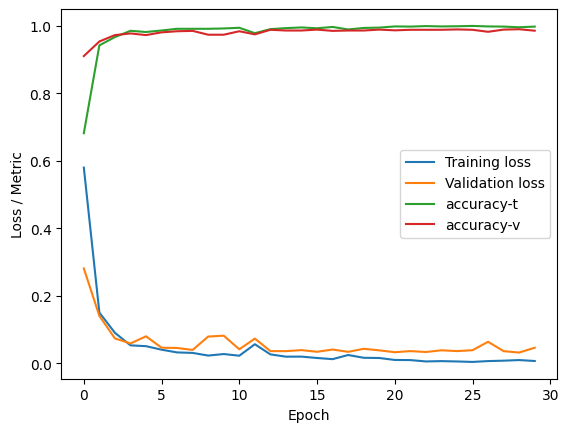

*** STATISTICS for Training Data ***
Accuracy        0.9990
Sensitivity     0.9980
Specificity     1.0000
Loss            0.0043

*** STATISTICS for Validation Data ***
Accuracy        0.9849
Sensitivity     0.9749
Specificity     0.9955
Loss            0.0466



In [21]:
# Load the dataset, MNIST-56
x_trn, d_trn, x_val, d_val, width, height = loadMNIST56()

# Container for CNN layers that will be used to construct the Network
layers = OrderedDict()

# First convolutional layer
layers["conv1"] = nn.Conv2d(in_channels=1, out_channels=4,
                            kernel_size=(3, 3))
layers["act1"] = nn.ReLU()
layers["mp1"] = nn.MaxPool2d((2, 2))

# Second convolutional layer
layers["conv2"] = nn.Conv2d(4, 4, 3) # in_channels, out_channels, kernel size
layers["act2"] = nn.ReLU()
layers["mp2"] = nn.MaxPool2d((2, 2))

# Fully connected MLP layers.
# Use one input image to compute the number of nodes after convolution layers.
n_features = nn.Sequential(layers)(Tensor(x_trn[0])).numel()
layers["flat"] = nn.Flatten()
layers["mlp"] = nn.Linear(n_features, 10)
layers["amlp"] = nn.ReLU()
# Output layer
layers["out"] = nn.Linear(10, 1)
layers["aout"] = nn.Sigmoid()

model_ex1 = Network(layers, l2regularization=0).to(device)

# Hyperparameters
opt_method = torch.optim.Adam   # minimization method
learning_rate = 0.005           # learning rate
loss_fn = nn.BCELoss()          # loss function, binary cross entropy
number_epochs = 30
minibatch_size = 64

# Additional metrics to print {name: metric}
metrics = {'accuracy': BinaryAccuracyMetric()}

# Print a summary of the model
print(model_ex1)

# Set up the optimizer
optimizer = opt_method(model_ex1.parameters(), lr=learning_rate)

# Create datasets and batch loaders for the training and test data on the GPU or CPU
dset_trn = TensorDataset(torch.tensor(x_trn, device=device, dtype=dtype_torch),
                         torch.tensor(d_trn, device=device, dtype=dtype_torch))
dl_trn = DataLoader(dset_trn, batch_size=minibatch_size, shuffle=True)

dset_val = TensorDataset(torch.tensor(x_val, device=device, dtype=dtype_torch),
                         torch.tensor(d_val, device=device, dtype=dtype_torch))
dl_val = DataLoader(dset_val)


# Train the network and print the progress
train_loss, val_loss, metrics_res = train_loop(
    model=model_ex1,
    train_dataloader=dl_trn,
    val_dataloader=dl_val,
    loss_fn=loss_fn,
    metrics=metrics,
    optimizer=optimizer,
    print_every=5,
    epochs=number_epochs)

# Plot the training history
plot_training(train_loss, val_loss, metrics_res)

# Call the stats function to print out statistics for binary classification problems
stats_classification(model_ex1, dset_trn, loss_fn=loss_fn, label="Training")
stats_classification(model_ex1, dset_val, loss_fn=loss_fn, label="Validation")

### Question 2
This image classification problem should be relatively easy since a "5" has some distinct differences from a "6". Experiment with the architecture of the CNN model and try to make it smaller (in terms of the number of trainable parameters), but with the same almost perfect validation accuracy (>98%). **How many parameters do you have in your trimmed model? What is your architecture?**

**Hint:** There is of course very many ways you can make a smaller architecture. You do not need to test all of them!

There are 67 trainable parameters in this model.

Architecture:

Input: 1x28x28 image

-> Conv2d(1->2, 3x3) -> ReLU -> MaxPool2d(2)

-> Conv2d(2->1, 3x3) -> ReLU -> MaxPool2d(2)

-> Flatten (25 features)

-> Linear (25->1) -> ReLU

-> Linear (1->1) -> Sigmoid

Network(
  (layer_stack): Sequential(
    (conv1): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
    (act1): ReLU()
    (mp1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1))
    (act2): ReLU()
    (mp2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (flat): Flatten(start_dim=1, end_dim=-1)
    (mlp): Linear(in_features=50, out_features=2, bias=True)
    (amlp): ReLU()
    (out): Linear(in_features=2, out_features=1, bias=True)
    (aout): Sigmoid()
  )
)
Trainable parameters: 163
Named parameters:
  conv1.weight: 18
  conv1.bias: 2
  conv2.weight: 36
  conv2.bias: 2
  mlp.weight: 100
  mlp.bias: 2
  out.weight: 2
  out.bias: 1

Epoch 1       train 0.670477  validation 0.535138  accuracy-t 0.505500 accuracy-v 0.761622
Epoch 6       train 0.056335  validation 0.085606  accuracy-t 0.978500 accuracy-v 0.967568
Epoch 11      train 0.044883  validati

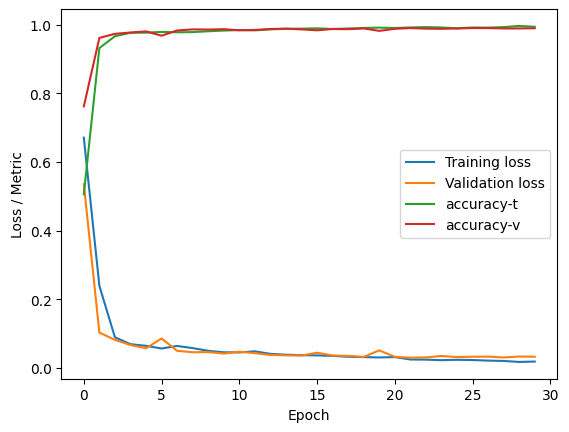

*** STATISTICS for Training Data ***
Accuracy        0.9960
Sensitivity     0.9980
Specificity     0.9940
Loss            0.0157

*** STATISTICS for Validation Data ***
Accuracy        0.9892
Sensitivity     0.9916
Specificity     0.9865
Loss            0.0323



In [61]:
# Load the dataset, MNIST-56
x_trn, d_trn, x_val, d_val, width, height = loadMNIST56()

# Container for CNN layers that will be used to construct the Network
layers = OrderedDict()

# First convolutional layer
layers["conv1"] = nn.Conv2d(in_channels=1, out_channels=2,
                            kernel_size=(3, 3))
layers["act1"] = nn.ReLU()
layers["mp1"] = nn.MaxPool2d((2, 2))

# Second convolutional layer
layers["conv2"] = nn.Conv2d(2, 2, 3) # in_channels, out_channels, kernel size
layers["act2"] = nn.ReLU()
layers["mp2"] = nn.MaxPool2d((2, 2))

# Fully connected MLP layers.
# Use one input image to compute the number of nodes after convolution layers.
n_features = nn.Sequential(layers)(Tensor(x_trn[0])).numel()
layers["flat"] = nn.Flatten()
layers["mlp"] = nn.Linear(n_features, 2)
layers["amlp"] = nn.ReLU()
# Output layer
layers["out"] = nn.Linear(2, 1)
layers["aout"] = nn.Sigmoid()

model_ex1 = Network(layers, l2regularization=0).to(device)

# Hyperparameters
opt_method = torch.optim.Adam   # minimization method
learning_rate = 0.005           # learning rate
loss_fn = nn.BCELoss()          # loss function, binary cross entropy
number_epochs = 30
minibatch_size = 64

# Additional metrics to print {name: metric}
metrics = {'accuracy': BinaryAccuracyMetric()}

# Print a summary of the model
print(model_ex1)

# Set up the optimizer
optimizer = opt_method(model_ex1.parameters(), lr=learning_rate)

# Create datasets and batch loaders for the training and test data on the GPU or CPU
dset_trn = TensorDataset(torch.tensor(x_trn, device=device, dtype=dtype_torch),
                         torch.tensor(d_trn, device=device, dtype=dtype_torch))
dl_trn = DataLoader(dset_trn, batch_size=minibatch_size, shuffle=True)

dset_val = TensorDataset(torch.tensor(x_val, device=device, dtype=dtype_torch),
                         torch.tensor(d_val, device=device, dtype=dtype_torch))
dl_val = DataLoader(dset_val)


# Train the network and print the progress
train_loss, val_loss, metrics_res = train_loop(
    model=model_ex1,
    train_dataloader=dl_trn,
    val_dataloader=dl_val,
    loss_fn=loss_fn,
    metrics=metrics,
    optimizer=optimizer,
    print_every=5,
    epochs=number_epochs)

# Plot the training history
plot_training(train_loss, val_loss, metrics_res)

# Call the stats function to print out statistics for binary classification problems
stats_classification(model_ex1, dset_trn, loss_fn=loss_fn, label="Training")
stats_classification(model_ex1, dset_val, loss_fn=loss_fn, label="Validation")

# CellName: Ex2 (#11)
**CellType: Exercise**  
**Cell instruction: Instructions for question 3**

You are now going to take a look into the CNN model. There are many attempts to visualize how the CNN model is making classifications. We will here just look at the different layer outputs given an input image. The function `layerVisualization`, found in cell #5 does the following:
* Use one selected image from the supplied dataset.
* Find some named layers and temporarily attach a "hook" to them to copy their output.
* Make a forward pass through the CNN, remembering intermediate values for the named layers.
* Plot all of the "filters" (channels) for each of the layers.
* Through the selection of layers, you can e.g. select to plot before or after MaxPooling.

You pass the model that you want to visualize to the `layerVisualization` function. If you do not change the variable names in cell Ex1, it should be `model_ex1`.

## Question 3
Train a CNN for the "5" vs "6" problem! As a suggestion use the following CNN (where "dense" denotes a fully connected layer, i.e. Linear+activation):

***3x(3x3 kernel) - maxpool - 3x(3x3 kernel) - maxpool - (flatten) - dense(5) - dense(1)***

Make sure that your trained model gives good validation results (i.e. > 95% accuracy). Having such a model, you can run the cell below. There are two parameters you need to specify, `idx` and `layers_vis`. As you can see, `layers_vis` is a list of named layers to visualize; you can specify `"act1"` etc. to plot the filters before maxpooling, or `"mp1"` etc. to show the result after maxpooling. The image to show is selected by the index `idx`. As an example, the following values represent,
* idx=1 number "6"
* idx=2 number "5"
* idx=3 another number "6"
* idx=5 another number "5"

**Can you find and describe some property in the filters that makes sense when it comes to separating "5" from "6"?**

Hint! If you repeat the training you most likely get a new network and other filters!

From the layer visualzations, we can observe that the convolution filters learn progressively more task-specific features as the depth increses. In the early layers (e.g. ´act1´ and ´act2´), the filters detect mainly to simple local features, while in the deeper layers (especially just before ´mp2´), the activation correspond to class-discriminative shape properties that are relevant for separating the digits 5 and 6. Specifically, in the layer ´act5´ to ´act6´, a meaningful distinction starts to appear. The digit 6 contains a closed or nearly closed loop in its lower part while the digit 5 instead has an open structure, with a sharp turn but no closed loop.

Therefore, filters that activate strongly for rounded, enclosed shapes tend to respond more to 6, while filters that respond to open curves or angular bends respond more to 5.


Network(
  (layer_stack): Sequential(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (act1): ReLU()
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (act2): ReLU()
    (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (act3): ReLU()
    (mp1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (act4): ReLU()
    (conv5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (act5): ReLU()
    (conv6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (act6): ReLU()
    (mp2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (flat): Flatten(start_dim=1, end_dim=-1)
    (mlp): Linear(in_features=32, out_features=5, bias=True)
    (amlp): ReLU()
    (out): Linear(in_features=5, out_features=1, bias=True)
    (aout): Sigmoid()
  )
)
Trainable parameters: 3171
Named parameters:
  conv1.weight: 72
  conv1.bias:

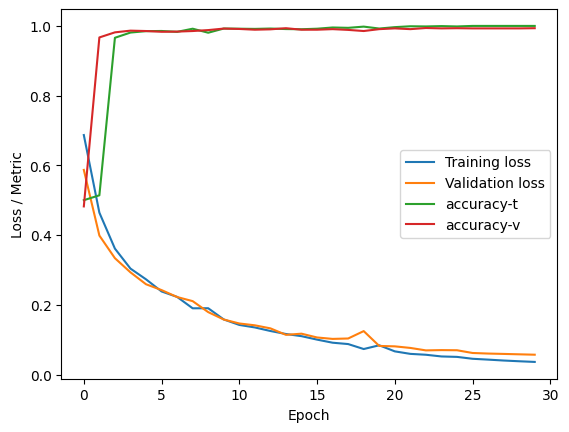

*** STATISTICS for Training Data ***
Accuracy        0.9995
Sensitivity     1.0000
Specificity     0.9990
Loss            0.0355

*** STATISTICS for Validation Data ***
Accuracy        0.9930
Sensitivity     0.9937
Specificity     0.9922
Loss            0.0571



In [62]:
# Load the dataset, MNIST-56
x_trn, d_trn, x_val, d_val, width, height = loadMNIST56()

# Container for CNN layers that will be used to construct the Network
layers = OrderedDict()

# First convolutional layer
layers["conv1"] = nn.Conv2d(in_channels=1, out_channels=8,
                            kernel_size=(3, 3))
layers["act1"] = nn.ReLU()

layers["conv2"] = nn.Conv2d(in_channels=8, out_channels=8,
                            kernel_size=(3, 3))
layers["act2"] = nn.ReLU()

layers["conv3"] = nn.Conv2d(in_channels=8, out_channels=8,
                            kernel_size=(3, 3))
layers["act3"] = nn.ReLU()

layers["mp1"] = nn.MaxPool2d((2, 2))

# Second convolutional layer
layers["conv4"] = nn.Conv2d(in_channels=8, out_channels=8,
                            kernel_size=(3, 3))
layers["act4"] = nn.ReLU()

layers["conv5"] = nn.Conv2d(in_channels=8, out_channels=8,
                            kernel_size=(3, 3))
layers["act5"] = nn.ReLU()

layers["conv6"] = nn.Conv2d(in_channels=8, out_channels=8,
                            kernel_size=(3, 3))
layers["act6"] = nn.ReLU()

layers["mp2"] = nn.MaxPool2d((2, 2))

# Fully connected MLP layers.
# Use one input image to compute the number of nodes after convolution layers.
n_features = nn.Sequential(layers)(Tensor(x_trn[0])).numel()
layers["flat"] = nn.Flatten()
layers["mlp"] = nn.Linear(n_features, 5)
layers["amlp"] = nn.ReLU()
# Output layer
layers["out"] = nn.Linear(5, 1)
layers["aout"] = nn.Sigmoid()

model_ex2 = Network(layers, l2regularization=0).to(device)

# Hyperparameters
opt_method = torch.optim.Adam   # minimization method
learning_rate = 0.005           # learning rate
loss_fn = nn.BCELoss()          # loss function, binary cross entropy
number_epochs = 30
minibatch_size = 64

# Additional metrics to print {name: metric}
metrics = {'accuracy': BinaryAccuracyMetric()}

# Print a summary of the model
print(model_ex2)

# Set up the optimizer
optimizer = opt_method(model_ex2.parameters(), lr=learning_rate)

# Create datasets and batch loaders for the training and test data on the GPU or CPU
dset_trn = TensorDataset(torch.tensor(x_trn, device=device, dtype=dtype_torch),
                         torch.tensor(d_trn, device=device, dtype=dtype_torch))
dl_trn = DataLoader(dset_trn, batch_size=minibatch_size, shuffle=True)

dset_val = TensorDataset(torch.tensor(x_val, device=device, dtype=dtype_torch),
                         torch.tensor(d_val, device=device, dtype=dtype_torch))
dl_val = DataLoader(dset_val)


# Train the network and print the progress
train_loss, val_loss, metrics_res = train_loop(
    model=model_ex2,
    train_dataloader=dl_trn,
    val_dataloader=dl_val,
    loss_fn=loss_fn,
    metrics=metrics,
    optimizer=optimizer,
    print_every=5,
    epochs=number_epochs)

# Plot the training history
plot_training(train_loss, val_loss, metrics_res)

# Call the stats function to print out statistics for binary classification problems
stats_classification(model_ex2, dset_trn, loss_fn=loss_fn, label="Training")
stats_classification(model_ex2, dset_val, loss_fn=loss_fn, label="Validation")

Prediction:  [[0.9341008]]
Target    :  [1.]


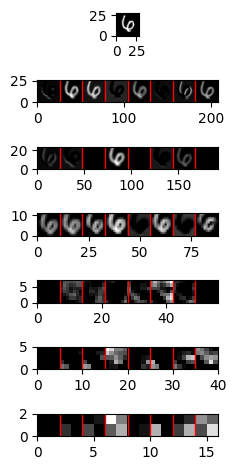

In [64]:
# The index of the input image to show
idx = 4

# The names of the layers to visualize
layers_vis = ["act1", "act2","mp1","act5","act6","mp2"]

# Call the visualization method, giving the model and the validation data to display
layerVisualization(model_ex2, layers_vis, x_val, d_val, idx)

Prediction:  [[1.496892e-11]]
Target    :  [0.]


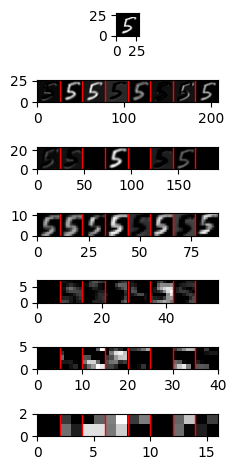

In [65]:
# The index of the input image to show
idx = 5

# The names of the layers to visualize
layers_vis = ["act1", "act2","mp1","act5","act6","mp2"]

# Call the visualization method, giving the model and the validation data to display
layerVisualization(model_ex2, layers_vis, x_val, d_val, idx)

# CellName: Ex3 (#12)
**CellType: Exercise**  
**Cell instruction: Instructions for question 4-5**

## CNN for image classification

In this exercise you are going to train a CNN that can separate between circles/squares/triangles found in the CRT dataset, and the three different types of rectangles found in the R3 dataset. You will use 500 training images and 1000 validation images. Code is provided for loading the data, training the model and presenting the result. Your task is to define the actual CNN model and see how it performs. For the following two questions you can optimize the model based on the validation performance. Here we assume that 1000 validation images are many enough for "model selection overtraining bias" to be small.

### Question 4
Define your own CNN model for classifying the images in the CRT data into three classes. **Provide the details of your CNN model and present the validation result.**

**Hint:** Remember the difference between a binary classifier and a multi-class classifier!
After the last layer, you will need a layer with `nn.Softmax(dim=1)`. (Here dim is the dimension that will be softmaxed; dim=0 would refer to the index of the input data in the mini-batch.)

### Question 5
Define your own CNN model for classifying the images in the R3 data into three classes. **Provide the details of your CNN model and present the validation result.** **Why is this a more difficult problem than Question 4?**


### Bonus task
The bonus tasks are provided if you have extra time and want to continue to explore the CNNs. **These tasks are not required for the course and does not influence any grading**.

You can use the `layerVisualization` method also for the above models (Q4 and Q5). It will show you the different filter outputs. Again try to understand the features the different filter learn to separate between circles-triangles-rectangles, or the rectangles for the R3 dataset.

In [ ]:
# Load the CRT dataset (Question 4)
x_trn, d_trn, x_val, d_val, width, height = loadImagesCRT()

# Load the R3 dataset (Question 5)
#x_trn, d_trn, x_val, d_val, width, height = loadImagesR3()

print('Training data input shape: ', x_trn.shape)
print('Training data output shape: ', d_trn.shape)
print('Validation data input shape: ', x_val.shape)
print('Validation data output shape: ', d_val.shape)

# Container for CNN layers that will be used to construct the Network
layers = OrderedDict()

#
# YOUR CODE HERE
#

model_ex3 = Network(layers, l2regularization=0).to(device)

# Hyperparameters
opt_method = torch.optim.Adam   # minimization method
learning_rate = 0.003           # learning rate
loss_fn = nn.CrossEntropyLoss() # loss function, categorical cross entropy
number_epochs = 50
minibatch_size = 50

# Additional metrics to print {name: metric}
metrics = {'accuracy': ClassificationAccuracyMetric()}

# Print a summary of the model
print(model_ex3)

# Set up the optimizer
optimizer = opt_method(model_ex3.parameters(), lr=learning_rate)

# Create datasets and batch loaders for the training and test data on the GPU or CPU
dset_trn = TensorDataset(torch.tensor(x_trn, device=device, dtype=dtype_torch),
                         torch.tensor(d_trn, device=device, dtype=dtype_torch))
dl_trn = DataLoader(dset_trn, batch_size=minibatch_size, shuffle=True)

dset_val = TensorDataset(torch.tensor(x_val, device=device, dtype=dtype_torch),
                         torch.tensor(d_val, device=device, dtype=dtype_torch))
dl_val = DataLoader(dset_val)


# Train the network and print the progress
train_loss, val_loss, metrics_res = train_loop(
    model=model_ex3,
    train_dataloader=dl_trn,
    val_dataloader=dl_val,
    loss_fn=loss_fn,
    metrics=metrics,
    optimizer=optimizer,
    print_every=5,
    epochs=number_epochs)

# Plot the training history
plot_training(train_loss, val_loss, metrics_res)

# Plot confusion matrix and print some classification statistics
make_cm_plot(model_ex3, x_val, d_val, "Validation")

In [ ]:
# The index of the input image to show
idx = 5

# The names of the layers to visualize
layers_vis = ["act1"]

# Call the visualization method, giving the model and the validation data to display
layerVisualization(model_ex3, layers_vis, x_val, d_val, idx)

### Question 4
Define your own CNN model for classifying the images in the CRT data into three classes. **Provide the details of your CNN model and present the validation result.**

**Hint:** Remember the difference between a binary classifier and a multi-class classifier!
After the last layer, you will need a layer with `nn.Softmax(dim=1)`. (Here dim is the dimension that will be softmaxed; dim=0 would refer to the index of the input data in the mini-batch.)

Training data input shape:  (500, 1, 64, 64)
Training data output shape:  (500, 3)
Validation data input shape:  (1000, 1, 64, 64)
Validation data output shape:  (1000, 3)
Network(
  (layer_stack): Sequential(
    (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (act1): ReLU()
    (mp1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
    (act2): ReLU()
    (mp2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (flat): Flatten(start_dim=1, end_dim=-1)
    (mlp): Linear(in_features=784, out_features=4, bias=True)
    (amlp): ReLU()
    (out): Linear(in_features=4, out_features=3, bias=True)
  )
)
Trainable parameters: 3343
Named parameters:
  conv1.weight: 36
  conv1.bias: 4
  conv2.weight: 144
  conv2.bias: 4
  mlp.weight: 3136
  mlp.bias: 4
  out.weight: 12
  out.bias: 3

Epoch 1       train 1.065716  validation 1.005368  accuracy-t 0.4

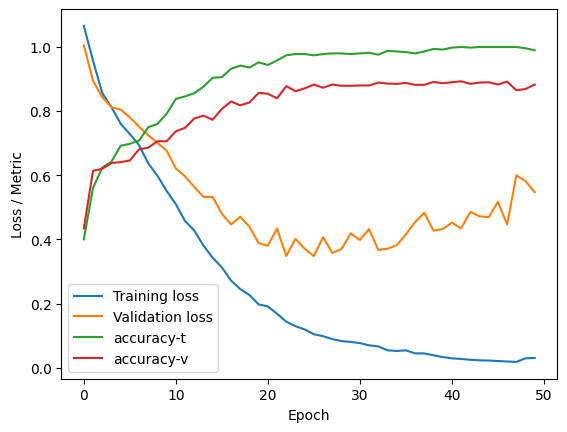

*** Result for Validation ***


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


log_loss:   0.4433
accuracy:   0.8830

              precision    recall  f1-score   support

     class 1       0.95      0.95      0.95       320
     class 2       0.81      0.89      0.85       355
     class 3       0.90      0.81      0.85       325

    accuracy                           0.88      1000
   macro avg       0.89      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000



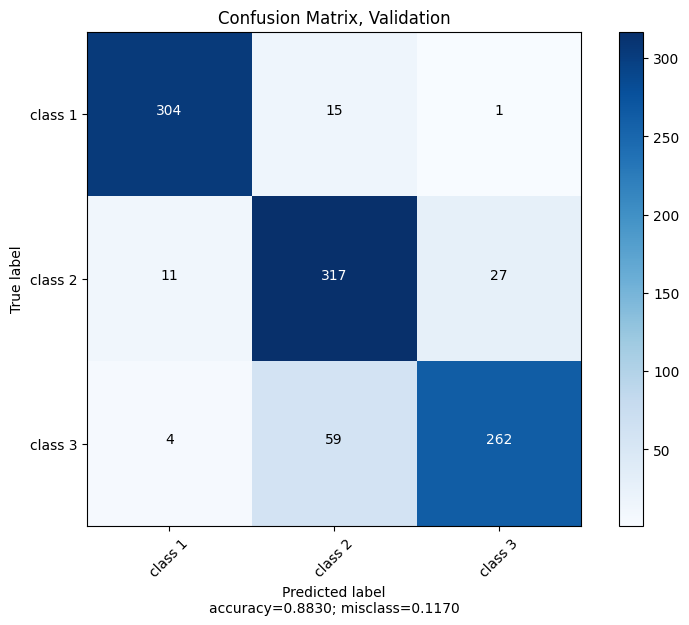

In [82]:
# Load the CRT dataset (Question 4)
x_trn, d_trn, x_val, d_val, width, height = loadImagesCRT()

# Load the R3 dataset (Question 5)
#x_trn, d_trn, x_val, d_val, width, height = loadImagesR3()

print('Training data input shape: ', x_trn.shape)
print('Training data output shape: ', d_trn.shape)
print('Validation data input shape: ', x_val.shape)
print('Validation data output shape: ', d_val.shape)

# Container for CNN layers that will be used to construct the Network
layers = OrderedDict()

#
# First convolutional layer
layers["conv1"] = nn.Conv2d(in_channels=1, out_channels=4,
                            kernel_size=(3, 3))
layers["act1"] = nn.ReLU()
layers["mp1"] = nn.MaxPool2d((2, 2))

# Second convolutional layer
layers["conv2"] = nn.Conv2d(4, 4, 3) # in_channels, out_channels, kernel size
layers["act2"] = nn.ReLU()
layers["mp2"] = nn.MaxPool2d((2, 2))

# Fully connected MLP layers.
# Use one input image to compute the number of nodes after convolution layers.
n_features = nn.Sequential(layers)(Tensor(x_trn[0])).numel()
layers["flat"] = nn.Flatten()
layers["mlp"] = nn.Linear(n_features, 4)
layers["amlp"] = nn.ReLU()
# Output layer
layers["out"] = nn.Linear(4, 3)
#layers["aout"] = nn.Sigmoid()
#

model_ex3 = Network(layers, l2regularization=0).to(device)

# Hyperparameters
opt_method = torch.optim.Adam   # minimization method
learning_rate = 0.003           # learning rate
loss_fn = nn.CrossEntropyLoss() # loss function, categorical cross entropy
number_epochs = 50
minibatch_size = 64

# Additional metrics to print {name: metric}
metrics = {'accuracy': ClassificationAccuracyMetric()}

# Print a summary of the model
print(model_ex3)

# Set up the optimizer
optimizer = opt_method(model_ex3.parameters(), lr=learning_rate)

# Create datasets and batch loaders for the training and test data on the GPU or CPU
dset_trn = TensorDataset(torch.tensor(x_trn, device=device, dtype=dtype_torch),
                         torch.tensor(d_trn, device=device, dtype=dtype_torch))
dl_trn = DataLoader(dset_trn, batch_size=minibatch_size, shuffle=True)

dset_val = TensorDataset(torch.tensor(x_val, device=device, dtype=dtype_torch),
                         torch.tensor(d_val, device=device, dtype=dtype_torch))
dl_val = DataLoader(dset_val)


# Train the network and print the progress
train_loss, val_loss, metrics_res = train_loop(
    model=model_ex3,
    train_dataloader=dl_trn,
    val_dataloader=dl_val,
    loss_fn=loss_fn,
    metrics=metrics,
    optimizer=optimizer,
    print_every=5,
    epochs=number_epochs)

# Plot the training history
plot_training(train_loss, val_loss, metrics_res)

# Plot confusion matrix and print some classification statistics
make_cm_plot(model_ex3, x_val, d_val, "Validation")

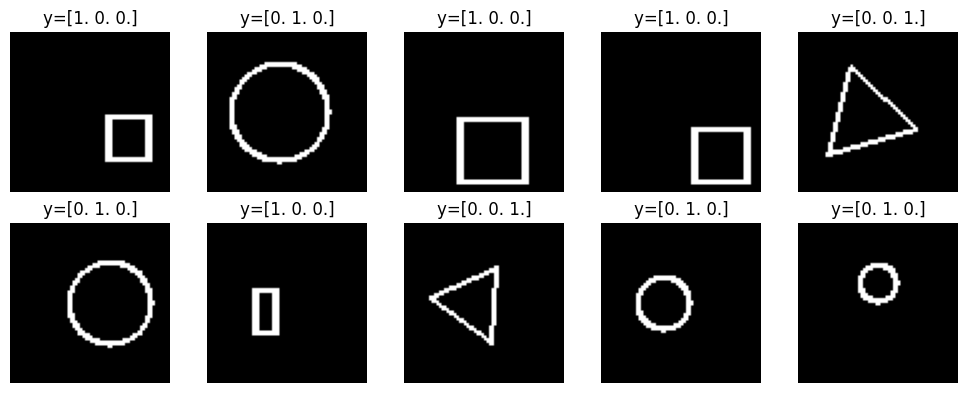

In [75]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    ax.imshow(x_trn[i, 0], cmap="gray")
    ax.set_title(f"y={d_trn[i]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


### Question 5
Define your own CNN model for classifying the images in the R3 data into three classes. **Provide the details of your CNN model and present the validation result.** **Why is this a more difficult problem than Question 4?**

In [ ]:
# Load the CRT dataset (Question 4)
x_trn, d_trn, x_val, d_val, width, height = loadImagesR3()

# Load the R3 dataset (Question 5)
#x_trn, d_trn, x_val, d_val, width, height = loadImagesR3()

print('Training data input shape: ', x_trn.shape)
print('Training data output shape: ', d_trn.shape)
print('Validation data input shape: ', x_val.shape)
print('Validation data output shape: ', d_val.shape)

# Container for CNN layers that will be used to construct the Network
layers = OrderedDict()

#
# First convolutional layer
layers["conv1"] = nn.Conv2d(in_channels=1, out_channels=2,
                            kernel_size=(3, 3))
layers["act1"] = nn.ReLU()
layers["mp1"] = nn.MaxPool2d((2, 2))

# Second convolutional layer
layers["conv2"] = nn.Conv2d(2, 2, 3) # in_channels, out_channels, kernel size
layers["act2"] = nn.ReLU()
layers["mp2"] = nn.MaxPool2d((2, 2))

# Fully connected MLP layers.
# Use one input image to compute the number of nodes after convolution layers.
n_features = nn.Sequential(layers)(Tensor(x_trn[0])).numel()
layers["flat"] = nn.Flatten()
layers["mlp"] = nn.Linear(n_features, 2)
layers["amlp"] = nn.ReLU()
# Output layer
layers["out"] = nn.Linear(2, 3)
#layers["aout"] = nn.Sigmoid()
#

model_ex3 = Network(layers, l2regularization=0).to(device)

# Hyperparameters
opt_method = torch.optim.Adam   # minimization method
learning_rate = 0.003           # learning rate
loss_fn = nn.CrossEntropyLoss() # loss function, categorical cross entropy
number_epochs = 50
minibatch_size = 64

# Additional metrics to print {name: metric}
metrics = {'accuracy': ClassificationAccuracyMetric()}

# Print a summary of the model
print(model_ex3)

# Set up the optimizer
optimizer = opt_method(model_ex3.parameters(), lr=learning_rate)

# Create datasets and batch loaders for the training and test data on the GPU or CPU
dset_trn = TensorDataset(torch.tensor(x_trn, device=device, dtype=dtype_torch),
                         torch.tensor(d_trn, device=device, dtype=dtype_torch))
dl_trn = DataLoader(dset_trn, batch_size=minibatch_size, shuffle=True)

dset_val = TensorDataset(torch.tensor(x_val, device=device, dtype=dtype_torch),
                         torch.tensor(d_val, device=device, dtype=dtype_torch))
dl_val = DataLoader(dset_val)


# Train the network and print the progress
train_loss, val_loss, metrics_res = train_loop(
    model=model_ex3,
    train_dataloader=dl_trn,
    val_dataloader=dl_val,
    loss_fn=loss_fn,
    metrics=metrics,
    optimizer=optimizer,
    print_every=5,
    epochs=number_epochs)

# Plot the training history
plot_training(train_loss, val_loss, metrics_res)

# Plot confusion matrix and print some classification statistics
make_cm_plot(model_ex3, x_val, d_val, "Validation")

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    ax.imshow(x_trn[i, 0], cmap="gray")
    ax.set_title(f"y={d_trn[i]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


# CellName: Ex4-1 (#13)
**CellType: Exercise**  
**Cell instruction: Instructions for question 6-9**

## RNN as a pulse converter
We will now look at recurrent networks! **Note**: This exercise is divided into three cells. The actual questions for this part can be found in cell *Ex4-3* below.

### Loading and visualizing the data
The cell below loads the training data and the validation data from existing binary python files and plots one set of training/validation data, both the input sequence and the target sequence. Run the cell by entering into the cell and press "CTRL Enter".

How is data generated? The input sequence consists of square pulses with varying length and height. The waiting time between the pulses is also varying within some predefined ranges. The lower limit is 2 times the length of the previous pulse. The target triangle pulse sequence is built from the input sequence as follows:
* the triangle pulse starts when the input square pulse have ended.
* the width of the triangle (at the base) is twice the width of the square pulse.
* the height of the triangle is the same as the height of the square pulse.

The task is now to learn this mapping using a recurrent neural network. There are 500 input/target sequences in the training data and 500 in the validation data, with a sequence length of 100 samples.

In [ ]:
# Load data from files
x_trn, d_trn = np.load("pulsedata1-trn.npy")
x_val, d_val = np.load("pulsedata1-val.npy")

# Uncomment below to load data for the bonus task
#x_trn, d_trn = np.load("pulsedata2-trn.npy")
#x_val, d_val = np.load("pulsedata2-val.npy")

print('Training data input shape:', x_trn.shape)
print('Training data output shape:', d_trn.shape)
print('Validation data input shape:', x_val.shape)
print('Validation data output shape:', d_val.shape)

# If this is set to True, then we have the reverse problem. Input triangle pulse, target square puls.
if False:
    # Torch doesn't like arrays with negative stride so we reverese+copy the data
    d_trn, x_trn = x_trn[:,::-1].copy(), d_trn[:,::-1].copy()
    d_val, x_val = x_val[:,::-1].copy(), d_val[:,::-1].copy()

ns, tlen = x_trn.shape
t = np.arange(tlen)

# The training / test case to look at
i = 3

# Plot
plt.figure(figsize=(15, 10), tight_layout=True)
plt.subplot(4,1,1)
plt.plot(t, x_trn[i,:])
plt.legend(['Training, input sequence'], loc=0)

plt.subplot(4,1,2)
plt.plot(t, d_trn[i,:])
plt.legend(['Training, target sequence'], loc=0)

plt.subplot(4,1,3)
plt.plot(t, x_val[i,:])
plt.legend(['Validation, input sequence'], loc=0)

plt.subplot(4,1,4)
plt.plot(t, d_val[i,:])
plt.legend(['Validation, target sequence'], loc=0)

# CellName: Ex4-2 (#14)
**CellType: Exercise**  
**Cell instruction: Instructions for question 6-9**

## RNN as a pulse converter
### Define the model and train
Here we are going to set up the model and train it. The network class and training functions are defined in cell #8. There are three different models to choose from:
* `nn.RNN`: Simple feedback weights where the output from a node is feeding back to itself. With several hidden nodes there are feedback weights to all other nodes in the layer.
* `nn.LSTM`: The LSTM unit
* `nn.GRU`: The GRU unit

When we say "RNN" in this notebook, we generally mean RNNs in general unless it's clear that we're referring to the "simple" RNN networks (i.e., `nn.RNN`).

The standard choice of activation function for `nn.RNN` is *tanh*, but you can also test *relu* (see the code below). When training this model, we will use a possible truncated BPTT approach, as defined in cell #8. In short, we have 500 training sequences, and we define a mini-batch size (*minibatch_size*) that selects *minibatch_size* of these sequences to train using the normal stochastic gradient descent idea. We then have a variable *truncationlen*, which is the length of the sequence to use in truncated BPTT. The default values for these are *minibatch_size=20* and *truncationlen=25*. If you want to train without the truncated BPTT approach, put *truncationlen=100*.

During training, we print the normalized training and validation error. Normalized means here that the loss (=MSE) is divided by the variance of the target signal. That means that a normalized error of 1 is poor, but below 0.1 (or so) the error is much smaller than the signal itself.

What you need to do in this cell is to define your model and train it.

In [ ]:
%%time

# The network type
net = nn.RNN
# net = nn.GRU
# net = nn.LSTM

# Number of hidden nodes (as a list if you want 2 or more layers)
nhidden = [5]

netargs = {}
# Uncomment below if you want ReLU for the simple nn.RNN network
# netargs['nonlinearity'] = 'relu'

model_ex4 = StatefulNetwork(net, nodes=nhidden, **netargs).to(device)

# Hyperparameters
opt_method = torch.optim.Adam   # minimization method
learning_rate = 0.003           # learning rate
loss_fn = nn.MSELoss()          # loss function, binary cross entropy
number_epochs = 25
minibatch_size = 20
truncationlen = 25

# Print a summary of the model
print(model_ex4)

# Set up the optimizer
optimizer = opt_method(model_ex4.parameters(), lr=learning_rate)

# Create datasets and batch loaders for the training and test data on the GPU or CPU
dset_trn = TensorDataset(torch.tensor(x_trn[..., None], device=device, dtype=dtype_torch),
                         torch.tensor(d_trn[..., None], device=device, dtype=dtype_torch))
dl_trn = DataLoader(dset_trn, batch_size=minibatch_size, shuffle=True)

dset_val = TensorDataset(torch.tensor(x_val[..., None], device=device, dtype=dtype_torch),
                         torch.tensor(d_val[..., None], device=device, dtype=dtype_torch))
dl_val = DataLoader(dset_val)

# Train the network and print the progress
train_loss, val_loss = train_TBPTT(
    model_ex4,
    epochs=number_epochs,
    truncationlen=truncationlen,
    train_dataloader=dl_trn,
    val_dataloader=dl_val,
    loss_fn=loss_fn,
    optimizer=optimizer,
    print_every=5
    )

# Plot the training history
plot_training(train_loss, val_loss)

# CellName: Ex4-3 (#15)
**CellType: Exercise**  
**Cell instruction: Instructions for question 6-9**

## RNN as a pulse converter
### Plot the result
In this cell we just plot the result for one of the first validation sequences. You can select which of these ones by an index (see the code).

## Questions
We are now finally at the point of asking questions. Whenever you define a new model and train it, you need to run the cell below to display the result for the newly trained model.

**Hint:** For all of the questions below, you will train different models. Keep an eye on how the training error is developing. If you see large fluctuations, you may to change the learning rate. The default value of 0.003 should be OK for most trainings.

### Question 6
(Just to get started!) Define a simple RNN model with 5 hidden nodes and train it for about 25 epochs. **What validation error do you obtain?**

**Hint:** You may have to train a couple of times to make sure that you did not end up in a "bad" local minimum the first time.

### Question 7
Test different models! Train the three different models (one hidden layer only) with the approximately the same number of trainable weights (around 150-200) and decide which of them that works best? **So, out of the three different models, *RNN*, *GRU* and *LSTM*, which one worked best using (approximately) the same number of weights?**

### Question 8
If you look at the top of cell *Ex4-1* you can, by changing False -> True, define the reverse problem (see top of the code cell). That is, input is the triangle pulse and target is the square pulse. This should be a more difficult problem! **Why?** **Present a RNN model that can "solve" this reverse problem (i.e. aim for a validation error below 0.05).**

**Hint:** Here you can experiment with two hidden layers of LSTM, GRU or simple RNN nodes

### Bonus task
The bonus task is provided if you have extra time and would like to test a more challenging problem. **This task is not required for the course and does not influence any grading**.

At the top of cell *Ex4-1*, you can uncomment the lines that read data for this bonus task.
This is similar to the first pulse conversion problem with a few modifications:

* the sample length is now 200.
* the triangle pulse starts when the square pulse has ended.
* the width of the triangle (at the base) depends on the two previous square pulses. The width is the mean of the widths of the two previous pulses.
* the height of the triangle depends on the two previous square pulses. The height is the mean of the heights of the two previous pulses.
* for the first triangle pulse, it is based on the previous square pulse only!

You can look at the new data in cell *Ex4-1*.

### Bonus question
Find the smallest model that can reach below **0.01** validation error. You may need to adjust the *minibatch_size*, *truncation_len*, and *learning_rate* hyperparameters to optimize the training.  



In [ ]:
i = 7
plt.figure(figsize=(15, 10), tight_layout=True)
plt.subplot(4,1,1)
plt.plot(t, x_trn[i,:], label='Training, input sequence')
plt.legend(loc=0)

plt.subplot(4,1,2)
plt.plot(t, d_trn[i,:], label='Training, target sequence')
pred = model_ex4.predict(x_trn[i,:,None])
plt.plot(t, pred[:,0], label='Training, output sequence')
plt.legend(loc=0)

plt.subplot(4,1,3)
plt.plot(t, x_val[i,:], label='Validation, input sequence')
plt.legend(loc=0)

plt.subplot(4,1,4)
plt.plot(t, d_val[i,:], label='Validation, target sequence')
pred = model_ex4.predict(x_val[i,:,None])
plt.plot(t, pred[:,0], label='Validation, output sequence')
plt.legend(loc=0)

# The report!

We have added intructions inside this report template. As you write your report, remove the instructions.

## Name

## Introduction
A few sentences about the overall theme of the exercise.

## Answers to questions
Provide enough information to clarify the meaning of your answers, so that they can be understood by someone who does not scroll up and read the entire instruction.

The questions are repeated here, for clarity of what is demanded. If it does not fit your style to quote them verbatim, change the format.

**Question 1**, CNN training  
What is your validation set performance in terms of the accuracy?

**Question 2**, model optimization  
How many parameters do you have in your trimmed model? What is your architecture?

**Question 3**, filter interpretation  
Can you find and describe some property in the filters that makes sense when it comes to separating "5" from "6"?

**Question 4**, CNN classification  
Provide the details of your CNN model for the CRT problem and present the validation result.

**Question 5**, harder classification  
Provide the details of your CNN model for the R3 problem and present the validation result.  
Why is this a more difficult problem than Question 4?

**Question 6**, RNN training  
What validation error do you obtain?

**Question 7**, RNN type comparison  
Present three different models, *RNN*, *GRU* and *LSTM*, using roughly the same number of weights.  
Which one worked best?

**Question 8**, harder RNN problem  
**(a)** Why is the reverse of the pulse problem (input signal and target signal change roles, time is reversed) more difficult?  
**(b)** Present a RNN model that can "solve" this reverse problem (i.e. below 0.05 in test error).


## Summary
Connect the summary to your introduction, to provide a brief overview of your findings.
